## What does this notebook do?
This notebook accesses data from [space-track.org](https://www.space-track.org/) to analyse Iridium, Kepler, OneWeb and Starlink satellites in orbit. The data is a part of space-track's [gp](https://www.space-track.org/documentation#api-basicSpaceDataGp) class ( general perturbations ), which is an efficient listing of the newest SGP4 keplerian element set for each artificial earth-orbiting object tracked by the 18th Space Defense Squadron.

## Requirements:
To use this notebook, replace 'username' and 'password' with your existing login credentials. Uncomment and run the required line below to ensure necessary packages are present locally/ in the cloud.

In [1]:
# %pip install matplotlib numpy pandas requests seaborn sgp4

In [2]:
from datetime import date
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from sgp4.api import Satrec

In [3]:
username = None
password = None

if not username or not password:
  print("Enter valid credentials")

siteCred = { 'identity': username, 'password': password }

In [4]:
# Error class to handle 'POST' and 'GET' errors
class HandleError(Exception):
    def __init__(self, args):
        Exception.__init__(self, "Exception raised with args {0}".format(args))
        self.args = args

# Function to calculate the altitude
def calculate_altitude(row):  
        objRec = Satrec.twoline2rv(row['TLE_LINE1'], row['TLE_LINE2'])
        objPos = objRec.sgp4(row['JULIAN_DATE'], row['FRACTION'])[1]
        satAlt = np.sqrt(objPos[0]**2 + objPos[1]**2 + objPos[2]**2) - 6371
        return satAlt

In [5]:
uriBase = "https://www.space-track.org"
requestLogin = "/ajaxauth/login"
requestQuery = "/basicspacedata/query"

# OBJECT_TYPE = PAYLOAD
satPayload = "/class/gp/OBJECT_TYPE/PAYLOAD"

# Filters data by OBJECT_NAME
iridium = "/OBJECT_NAME/~~IRIDIUM"

# Filters data by OBJECT_NAME
kepler = "/OBJECT_NAME/~~KEPLER"

# Filters data by OBJECT_NAME
oneweb = "/OBJECT_NAME/~~ONEWEB"

# Filters data by OBJECT_NAME
starlink = "/OBJECT_NAME/~~STARLINK"

# Filters data by LAUNCH_DATE
predicate1  = "/LAUNCH_DATE/%3C%3Enull"

# Orders the data by NORAD_CAT_ID
orderBy = "/orderby/NORAD_CAT_ID%20asc"

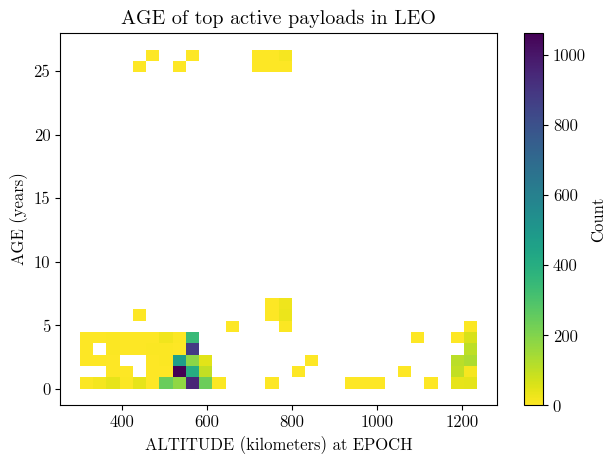

In [6]:
with requests.Session() as session:
    postCheck = session.post(uriBase + requestLogin, data = siteCred)
    if postCheck.status_code != 200:
            raise HandleError('POST')

    """
    Requests for PAYLOAD data where LAUNCH_DATE != null 
    and OBJECT_NAMEs of major LEO satellite operators 
    such as IRIDIUM, KEPLER, ONEWEB, STARLINK, and TELESAT.
    """
    response1 = session.get(uriBase + requestQuery + satPayload + iridium + predicate1 + orderBy)
    if response1.status_code != 200:
        raise HandleError('GET')
    
    response2 = session.get(uriBase + requestQuery + satPayload + kepler + predicate1 + orderBy)
    if response1.status_code != 200:
        raise HandleError('GET')
    
    response3 = session.get(uriBase + requestQuery + satPayload + oneweb + predicate1 + orderBy)
    if response1.status_code != 200:
        raise HandleError('GET')
    
    response4 = session.get(uriBase + requestQuery + satPayload + starlink + predicate1 + orderBy)
    if response1.status_code != 200:
        raise HandleError('GET')
    
    data1 = response1.text
    data2 = response2.text
    data3 = response3.text
    data4 = response4.text

    dataFrame1 = pd.read_json(io.StringIO(data1))
    dataFrame2 = pd.read_json(io.StringIO(data2))
    dataFrame3 = pd.read_json(io.StringIO(data3))
    dataFrame4 = pd.read_json(io.StringIO(data4))

    concatenatedDF = pd.concat([dataFrame1, dataFrame2, dataFrame3, dataFrame4],
                                ignore_index = True)
    
    """
    Using any available fonts is permissible for the plots, 
    but I chose CMU Serif for aesthetic reasons.
    For Ubuntu, you can install the font package fonts-cmu 
    (using sudo apt install fonts-cmu), which contains the fonts.
    """
    # plt.rcParams['font.family'] = "CMU Serif"
    # plt.rcParams['font.size'] = 12
    
    # Drops the PAYLOAD data where DECAY_DATE != null
    concatenatedDF = concatenatedDF[concatenatedDF['DECAY_DATE'].isnull()]
        
    # Plots the ALTITUDE (kilometers) at EPOCH vs INCLINATION for active payloads in LEO
    concatenatedDF['EPOCH'] = pd.to_datetime(concatenatedDF['EPOCH'])
    concatenatedDF['JULIAN_DATE'] = concatenatedDF['EPOCH'].apply(lambda x: int(x.to_julian_date()))
    concatenatedDF['FRACTION'] = concatenatedDF['EPOCH'].apply(lambda x: x.to_julian_date() - int(x.to_julian_date()))
    concatenatedDF['ALTITUDE'] = concatenatedDF.apply(lambda row: calculate_altitude(row), axis = 1)    
    
    # Plots the ALTITUDE (kilometers) at EPOCH vs LIFESPAN for active payloads in LEO
    concatenatedDF['LAUNCH_DATE'] = pd.to_datetime(concatenatedDF['LAUNCH_DATE'])
    concatenatedDF['DECAY_DATE'] = pd.to_datetime(date.today())
    concatenatedDF['LIFESPAN'] = ((concatenatedDF['DECAY_DATE'] - concatenatedDF['LAUNCH_DATE']).dt.days) / 365.25    
    sns.histplot(x = 'ALTITUDE', y = 'LIFESPAN', data = concatenatedDF, cmap = 'viridis_r', cbar = True, 
                 cbar_kws = {'label': 'Count'}, bins = 30)
    plt.xlabel("ALTITUDE (kilometers) at EPOCH")
    plt.ylabel("AGE (years)")
    plt.title("AGE of top active payloads in LEO")

    plt.tight_layout()
session.close()